In [1]:
out_file = 'U19-depth.h5'
model = 'U19_2019-09-18/first_model.p'
index = 'U19_2019-09-18/moseq2-index.timepoint.yaml'
tag_file = 'u19-tags.csv'
#out_file = 'PNKD_CT-depth.h5'
#model = 'PNKD_CT_2019-09-14/CT-first.p'
#index = 'PNKD_CT_2019-09-14/gender-genotype-index.yaml'
#tag_file = 'pnkd_ct-tags.csv'

In [2]:
from syl_slices import get_syl_slices

slices = get_syl_slices(model,index)

100%|██████████| 100/100 [00:04<00:00, 21.35it/s]


In [3]:
import pandas as pd

tags = pd.read_csv(tag_file)
tags.set_index('Syllable', inplace=True)

In [4]:
print(tags)

            Tag
Syllable       
0         pause
1          walk
2         pause
3         micro
4          dart
...         ...
87         rear
88         rear
89        micro
93         rear
98         rear

[92 rows x 1 columns]


In [5]:
slices_flat = []

for i in range(len(slices)):
    for inst in slices[i]:
        slices_flat.append(inst)
        slices_flat[-1].append(tags.loc[i].values[0])

In [6]:
print(len(slices_flat))
print(slices_flat[0])
print(slices_flat[-1])

79719
[(240, 248), '07f8363f-e642-4b6d-8744-d7a6933de1fc', 'U19_2019-09-18\\_aggregate_results/2019-09-08_15-22-08_9-8-19-u19-baseline_en2_results_00.h5', 'pause']
[(31645, 31671), '1f918806-1996-40c3-84c8-cc78ee20370d', 'U19_2019-09-18\\_aggregate_results/2019-09-10_14-03-31_9-8-19-u19-+24hrs_en6_results_00.h5', 'rear']


In [7]:
import numpy as np

max_len = 30
insts = np.full((len(slices_flat),max_len,80,80),-10,dtype=np.int8)

In [8]:
slices_df = pd.DataFrame(slices_flat,columns=['Frames','UUID','Path','Tag'])

In [9]:
import h5py
from progressbar import ProgressBar

pbar = ProgressBar()
tag_list = []
index = 0
for h_file in pbar(slices_df.Path.unique()):
    with h5py.File(h_file,'r') as f:
        frames = np.array(f['frames'])
    for _, row in slices_df.loc[slices_df['Path'] == h_file].iterrows():
        inst_len = row['Frames'][1]-row['Frames'][0]
        if inst_len < max_len:
            insts[index,0:inst_len] = frames[row['Frames'][0]:row['Frames'][1]]
        else:
            insts[index,0:max_len] = frames[row['Frames'][0]:row['Frames'][0]+max_len]
        tag_list.append(row['Tag'])
        index += 1

100% |########################################################################|


In [10]:
ascii_list = [n.encode('ascii','ignore') for n in tag_list]

In [11]:
insts = insts.reshape(-1,max_len,80,80,1)

In [12]:
print(insts.shape)

(79719, 30, 80, 80, 1)


In [13]:
hf = h5py.File(out_file,'w')
hf.create_dataset('Instances', data=insts)
hf.create_dataset('Tags', data=ascii_list)
hf.close()

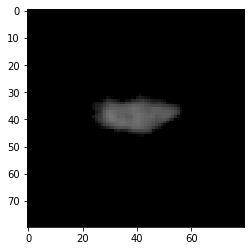

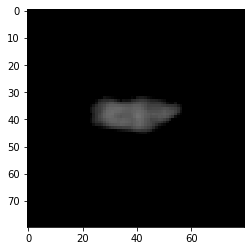

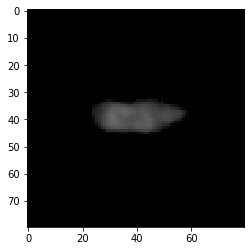

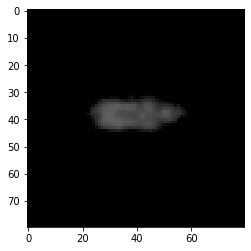

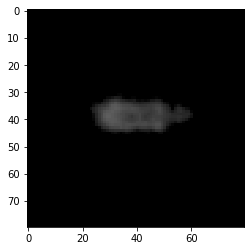

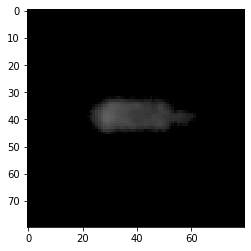

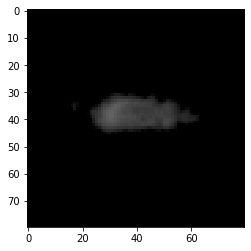

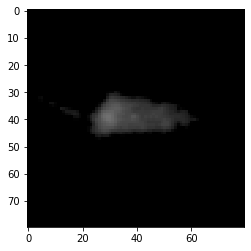

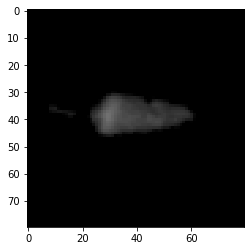

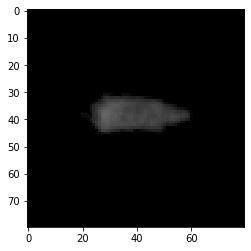

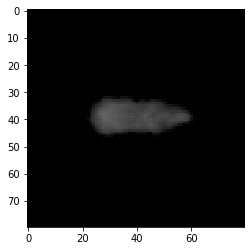

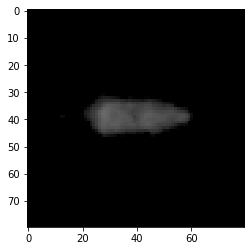

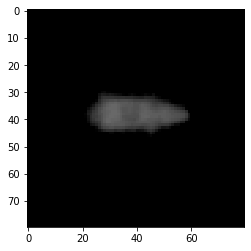

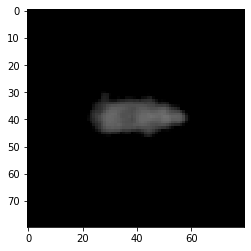

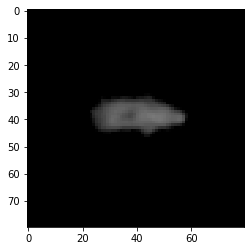

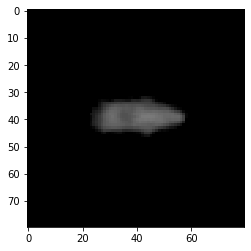

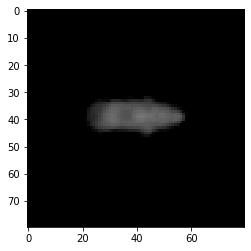

In [20]:
import os
import h5py
import matplotlib.pyplot as plt

hf = h5py.File(out_file,'r')
#print(hf['Frames'].shape)
#print(hf['Tags'][0:10])
#print(hf['Frames'][0])
t = 'dart'
n = 300
x = 0
for i in range(len(hf['Instances'])):
    if hf['Tags'][i].decode('unicode_escape') == t:
        if n > x:
            x += 1
        else:
            for j in range(len(hf['Instances'][i])):
                frame = hf['Instances'][i,j].reshape(80,80)
                if frame[0,0] == -10:
                    break
                plt.imshow(frame,cmap=plt.get_cmap('gray'),vmin=0,vmax=100)
                plt.savefig(os.path.join('frame_images',t+str(j)+'.png'))
                plt.show()
            break
hf.close()